In [1]:
import torch
from torch.autograd.functional import jacobian, hessian
from torch.autograd import grad
import torch.nn as nn
import torch.nn.functional as F

In [2]:
t = torch.linspace(0,10,steps=1000)

#position and velocity
q = torch.sin(t)
qdot = torch.cos(t)

#State (batch, n)
x = torch.stack((q,qdot), dim=1)
x = x.requires_grad_(True)

#For differentiation
#xv = x.requires_grad_(True)

#retrieve q and qdot from x
#q,qdot = torch.split(xv,1,1)

In [3]:
def lagrangian(x):
    q,qdot = torch.split(x,1,1)
    L = 0.5*q**2 - 0.5*qdot**2
    return L


In [4]:
##Investigate how gradient works

In [5]:
x = torch.rand((10,2), requires_grad = True)
L = lagrangian(x)

In [6]:
print('Inputs: ', x)
print('L: ', L)

Inputs:  tensor([[0.3144, 0.4181],
        [0.9707, 0.1466],
        [0.7181, 0.2044],
        [0.8618, 0.4884],
        [0.2316, 0.7406],
        [0.4844, 0.0977],
        [0.2374, 0.2783],
        [0.4277, 0.3732],
        [0.5354, 0.9350],
        [0.7992, 0.4353]], requires_grad=True)
L:  tensor([[-0.0380],
        [ 0.4604],
        [ 0.2369],
        [ 0.2521],
        [-0.2475],
        [ 0.1125],
        [-0.0106],
        [ 0.0218],
        [-0.2938],
        [ 0.2246]], grad_fn=<SubBackward0>)


In [7]:
L = L.sum()
L.backward()
print("Inputs: ", x)
print("Grad respect to inputs: ", x.grad)

Inputs:  tensor([[0.3144, 0.4181],
        [0.9707, 0.1466],
        [0.7181, 0.2044],
        [0.8618, 0.4884],
        [0.2316, 0.7406],
        [0.4844, 0.0977],
        [0.2374, 0.2783],
        [0.4277, 0.3732],
        [0.5354, 0.9350],
        [0.7992, 0.4353]], requires_grad=True)
Grad respect to inputs:  tensor([[ 0.3144, -0.4181],
        [ 0.9707, -0.1466],
        [ 0.7181, -0.2044],
        [ 0.8618, -0.4884],
        [ 0.2316, -0.7406],
        [ 0.4844, -0.0977],
        [ 0.2374, -0.2783],
        [ 0.4277, -0.3732],
        [ 0.5354, -0.9350],
        [ 0.7992, -0.4353]])


The autograd function only works on scalar output. Therefore, let say we have a scalar output $L([x,y])$ from a vector input. Let say we have a time series of the vector 
where 
$$ \mathbf{T} = \begin{bmatrix} x_1 & y_1 \\ x_2 & y_2\\ x_k & y_k \end{bmatrix} $$
and the output is 
$$ \mathbf{L} = \begin{bmatrix} L_1 \\ L_2\\ L_k \end{bmatrix}$$. 

We want to get the gradient of L in each time series as follows,
$$ Grad = \begin{bmatrix} \nabla L_1 \\ \nabla L_2 \\ \nabla L_k \end{bmatrix} $$.

We have to use $L.sum()$, because the autograd only works on scalar. The detail of the equation is as follows,

$$ s = \sum_{k=1}^n L_k$$

$$\frac{ds}{dT} = \begin{bmatrix} \frac{ds}{dT_{11}} & \frac{ds}{dT_{12}} \\ \frac{ds}{dT_{21}} & \frac{ds}{dT_{22}}\\ \frac{ds}{dT_{k1}} & \frac{ds}{dT_{k2}} \end{bmatrix}$$ 

$$  \frac{ds}{dT_{mn}} = \frac{ds}{d\mathbf{L}} \frac{d\mathbf{L}}{dT_{mn}}  = \frac{ds}{dL_m} \frac{dL_m}{dT_{mn}} = \frac{dL_m}{dT_{mn}}$$

$$\frac{ds}{dT} = \begin{bmatrix}  \frac{dL_1}{dT_{11}} & \frac{dL_1}{dT_{12}} \\ \frac{dL_2}{dT_{21}} & \frac{dL_2}{dT_{22}} \\ \frac{dL_k}{dT_{k1}} & \frac{dL_k}{dT_{k2}} = \end{bmatrix} = \begin{bmatrix} \nabla L_1 \\ \nabla L_2 \\ \nabla L_k \end{bmatrix}$$ 

Jacobian API

In [8]:
def exp_adder(x):
    return 2 * x[:,0].exp() + 3 * x[:,1]

x = torch.rand((1,2)) # arguments for the function
print(x)
torch.autograd.functional.jacobian(exp_adder, x)

tensor([[0.3265, 0.0961]])


tensor([[[2.7721, 3.0000]]])

In [9]:
inputs = torch.rand((5,2)) # arguments for the function
J = torch.autograd.functional.jacobian(exp_adder, inputs)
print('Input : ',inputs)
print('Output : ',exp_adder(inputs))
print('Jacobian : ', J)

Input :  tensor([[0.8960, 0.6795],
        [0.4097, 0.0734],
        [0.5018, 0.4115],
        [0.9174, 0.8155],
        [0.9733, 0.4220]])
Output :  tensor([6.9381, 3.2330, 4.5381, 7.4523, 6.5592])
Jacobian :  tensor([[[4.8997, 3.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [3.0127, 3.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [3.3035, 3.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [5.0058, 3.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [5.2931, 3.0000]]])


In [10]:
J[1][0]

tensor([0., 0.])

In [11]:
J.shape

torch.Size([5, 5, 2])

In [12]:
def exp_adder(x):
    return (2 * x[:,0].exp() + 3 * x[:,1]).sum()

In [13]:
x = torch.rand((5,2))
J = torch.autograd.functional.jacobian(exp_adder, x)
print('Input : ',x)
print('Output : ',exp_adder(x))
print('Jacobian : ', J)

Input :  tensor([[0.2592, 0.9879],
        [0.1781, 0.1152],
        [0.1690, 0.7684],
        [0.6942, 0.0919],
        [0.3582, 0.9985]])
Output :  tensor(23.1015)
Jacobian :  tensor([[2.5917, 3.0000],
        [2.3899, 3.0000],
        [2.3683, 3.0000],
        [4.0044, 3.0000],
        [2.8615, 3.0000]])


In [14]:
def lagrangian(x):
    q,qdot = torch.split(x,1,1)
    L = 0.5*q**2 - 0.5*qdot**2
    return L.sum()

In [15]:
x = torch.rand(10,2)
J = torch.autograd.functional.jacobian(lagrangian, x)
print('Input : ',x)
print('Output : ',lagrangian(x))
print('Jacobian : ', J)

Input :  tensor([[0.2589, 0.7283],
        [0.8457, 0.4379],
        [0.9986, 0.8173],
        [0.5520, 0.6557],
        [0.2466, 0.3238],
        [0.0845, 0.7693],
        [0.7452, 0.0801],
        [0.6558, 0.5502],
        [0.3556, 0.0304],
        [0.6367, 0.0996]])
Output :  tensor(0.4163)
Jacobian :  tensor([[ 0.2589, -0.7283],
        [ 0.8457, -0.4379],
        [ 0.9986, -0.8173],
        [ 0.5520, -0.6557],
        [ 0.2466, -0.3238],
        [ 0.0845, -0.7693],
        [ 0.7452, -0.0801],
        [ 0.6558, -0.5502],
        [ 0.3556, -0.0304],
        [ 0.6367, -0.0996]])


The explanation of the Jacobian API is written on the notebook 5/19/2021

Hessian API

In [16]:
def exp_adder(x):
    return (2 * x[:,0].exp() + 3 * x[:,1]**2).sum()

x = torch.rand((5,2)) # arguments for the function
H = hessian(exp_adder, x).sum(dim=2)
print('Input : ', x)
print('Output : ', exp_adder(x))
print('Hessian : ', H)

Input :  tensor([[0.6901, 0.3331],
        [0.1290, 0.6320],
        [0.7188, 0.9874],
        [0.1262, 0.6484],
        [0.3549, 0.8540]])
Output :  tensor(23.3937)
Hessian :  tensor([[[3.9879, 0.0000],
         [0.0000, 6.0000]],

        [[2.2755, 0.0000],
         [0.0000, 6.0000]],

        [[4.1041, 0.0000],
         [0.0000, 6.0000]],

        [[2.2690, 0.0000],
         [0.0000, 6.0000]],

        [[2.8521, 0.0000],
         [0.0000, 6.0000]]])


In [17]:
H.shape

torch.Size([5, 2, 2])

The explanation of the Jacobian API is written on the notebook 5/19/2021

In [18]:
def lagrangian(x):
    n = x.shape[1]//2
    q,qdot = torch.split(x,n,1)
    L = 0.5*q**2 - 0.5*qdot**2 + 0.5*q*qdot**2
    return L.sum()

In [19]:
x = torch.rand((10,4)) # arguments for the function
H = hessian(lagrangian, x).sum(dim=2)
print('Input : ', x)
print('Output : ', exp_adder(x))
print('Hessian : ', H)

Input :  tensor([[0.1452, 0.7026, 0.7781, 0.8673],
        [0.4157, 0.8429, 0.9204, 0.3090],
        [0.7768, 0.0019, 0.7617, 0.2753],
        [0.6507, 0.7734, 0.2069, 0.8695],
        [0.4335, 0.5789, 0.3780, 0.7283],
        [0.0179, 0.5452, 0.5661, 0.8866],
        [0.9447, 0.4274, 0.1887, 0.0168],
        [0.4208, 0.6091, 0.0025, 0.1601],
        [0.0303, 0.6443, 0.2913, 0.8749],
        [0.1066, 0.5320, 0.7896, 0.4431]])
Output :  tensor(42.1842)
Hessian :  tensor([[[ 1.0000,  0.0000,  0.7781,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.8673],
         [ 0.7781,  0.0000, -0.8548,  0.0000],
         [ 0.0000,  0.8673,  0.0000, -0.2974]],

        [[ 1.0000,  0.0000,  0.9204,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.3090],
         [ 0.9204,  0.0000, -0.5843,  0.0000],
         [ 0.0000,  0.3090,  0.0000, -0.1571]],

        [[ 1.0000,  0.0000,  0.7617,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.2753],
         [ 0.7617,  0.0000, -0.2232,  0.0000],
         [ 0

Using einsum vs using .sum(dim=2)m

In [20]:
x = torch.rand((10,6)) # arguments for the function
H = torch.einsum('ijkl -> ijl',hessian(lagrangian, x))
print('Input : ', x)
print('Output : ', exp_adder(x))
print('Hessian : ', H)

Input :  tensor([[5.6033e-01, 9.7945e-01, 2.1176e-01, 1.2123e-01, 7.2305e-01, 8.2903e-01],
        [8.2907e-01, 7.5946e-01, 9.1909e-01, 2.2669e-01, 1.8552e-01, 9.2746e-01],
        [1.1265e-01, 6.1006e-01, 2.7041e-01, 6.2300e-01, 5.9320e-01, 4.7950e-01],
        [7.3635e-01, 4.8141e-01, 9.7644e-01, 9.6046e-01, 8.4368e-01, 3.4040e-01],
        [9.9959e-01, 5.8719e-01, 1.4229e-02, 2.6146e-01, 4.9215e-01, 9.0941e-01],
        [2.8187e-04, 2.2194e-01, 3.8534e-01, 2.0476e-01, 1.2845e-03, 1.1312e-02],
        [7.6373e-01, 9.4885e-01, 9.7515e-01, 8.6025e-01, 4.6455e-01, 5.7075e-01],
        [9.2324e-02, 5.9089e-01, 1.7200e-01, 8.8841e-02, 5.2543e-01, 9.8354e-01],
        [5.5460e-02, 2.1777e-01, 2.3196e-01, 8.2891e-01, 1.2767e-01, 7.8567e-01],
        [4.6974e-01, 8.5317e-01, 3.1716e-01, 9.3978e-01, 7.7548e-01, 5.0140e-02]])
Output :  tensor(47.4107)
Hessian :  tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  1.2123e-01,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  1.0000e+00

In [21]:
torch.einsum('ijkl -> ijl',hessian(lagrangian, x)) == hessian(lagrangian,x).sum(2)

tensor([[[True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True]],

        [[True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True]],

        [[True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True]],

        [[True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
       

Sanity check with a simple pendulum

In [2]:
from scipy.integrate import solve_ivp
import numpy as np

In [3]:
l, m, g = 1, 1, 9.8
tau = 0
def Pendulum(t,x):
    return x[1], -(g/l)*np.sin(x[0]) + tau

def generate_data(func, time, init_values):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='RK45',rtol=1e-10,atol=1e-10)
    return sol.y.T, np.array([func(0,sol.y.T[i,:]) for i in range(sol.y.T.shape[0])],dtype=np.float64)

In [4]:
#generating simulated data
t = np.arange(0,10,0.01)
y_0 = np.array([np.pi/4, 0])
X,Xdot = generate_data(Pendulum, t, y_0)

In [5]:
import matplotlib.pyplot as plt

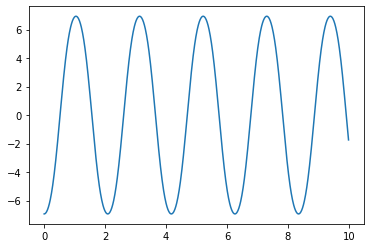

In [6]:
plt.plot(t,Xdot[:,1])

In [7]:
def lagrangian(x):
    n = x.shape[1]//2
    q,qdot = torch.split(x,n,dim=1)
    L = 0.5*qdot**2 + 9.8*torch.cos(q)
    return L.sum()

def forward(x):
        '''
        #input 
        x  : State of the system (q, qdot)

        #output
        qddot : Double derivation of q w.r.t time 
        '''
        if(torch.is_tensor(x)==False):
            x = torch.from_numpy(x)
        
        n = x.shape[1]//2 #number of generalized coordinate
        xv = torch.autograd.Variable(x, requires_grad=True)
        q, qdot = torch.split(xv, n, dim=1)

        #Since the state is in the form of q,qdot,
        #We need to splice the result
        
        #Shape (batch, (nxn) hessian corresponding to each input)
        A = torch.inverse(torch.einsum('ijkl -> ijl', hessian(lagrangian, xv, create_graph=True))[:, n:, n:])
        #Shape (batch, (n) gradient corresponding to each input)
        B = jacobian(lagrangian, xv, create_graph = True)[:,:n]
        #Shape (batch, (nxn) hessian corresponding to each input)
        C = torch.einsum('ijkl -> ijl', hessian(lagrangian, xv, create_graph=True))[:,n:, :n]

        qddot = torch.einsum('ijk, ik -> ij', A, (B - torch.einsum('ijk, ik -> ij', C, qdot))) 

        return q, qdot, qddot

In [8]:
q, qdot, qddot = forward(X)

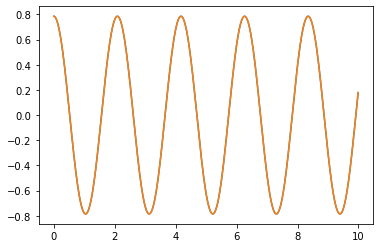

In [9]:
plt.plot(t,X[:,0])
plt.plot(t, q.detach())
plt.show()

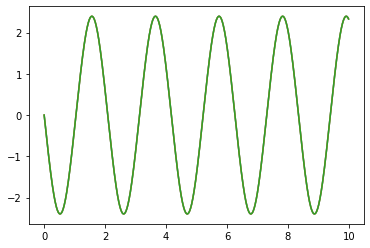

In [10]:
plt.plot(t,X[:,1])
plt.plot(t, Xdot[:,0])
plt.plot(t, qdot.detach())
plt.show()

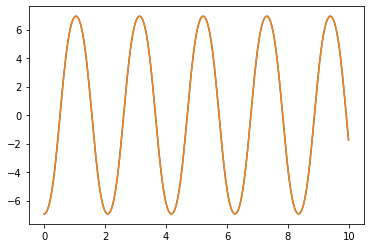

In [11]:
plt.plot(t, Xdot[:,1])
plt.plot(t, qddot.detach())
plt.show()

Sanity Check with a double pendulum

In [12]:
import time

def generate_data(func, time, init_values):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='RK45',rtol=1e-10,atol=1e-10)
    return sol.y.T, np.array([func(0,sol.y.T[i,:]) for i in range(sol.y.T.shape[0])],dtype=np.float64)

def pendulum(t,x):
    return x[1],-9.81*np.sin(x[0])

# Pendulum rod lengths (m), bob masses (kg).
L1, L2 = 1, 1
m1, m2 = 1, 1
# The gravitational acceleration (m.s-2).
g = 9.81

def doublePendulum(t,y,M=0.0):
    q1,q1_t,q2,q2_t = y
    q1_2t = (-L1*g*m1*np.sin(q1) - L1*g*m2*np.sin(q1) + M + m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t)/2 - m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t + 2*L1*(-L1*np.sin(q1)*q1_t**2 - L2*np.sin(q2)*q2_t**2)*np.cos(q1) - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t + 2*L1*(L1*np.cos(q1)*q1_t**2 + L2*np.cos(q2)*q2_t**2)*np.sin(q1))/2 - m2*(2*L1*L2*np.sin(q1)*np.sin(q2) + 2*L1*L2*np.cos(q1)*np.cos(q2))*(-L2*g*m2*np.sin(q2) + m2*(2*L2*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q2)*q2_t - 2*L2*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q2)*q2_t)/2 - m2*(2*L2*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q2)*q2_t + 2*L2*(-L1*np.sin(q1)*q1_t**2 - L2*np.sin(q2)*q2_t**2)*np.cos(q2) - 2*L2*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q2)*q2_t + 2*L2*(L1*np.cos(q1)*q1_t**2 + L2*np.cos(q2)*q2_t**2)*np.sin(q2))/2 - m2*(2*L1*L2*np.sin(q1)*np.sin(q2) + 2*L1*L2*np.cos(q1)*np.cos(q2))*(-L1*g*m1*np.sin(q1) - L1*g*m2*np.sin(q1) + M + m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t)/2 - m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t + 2*L1*(-L1*np.sin(q1)*q1_t**2 - L2*np.sin(q2)*q2_t**2)*np.cos(q1) - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t + 2*L1*(L1*np.cos(q1)*q1_t**2 + L2*np.cos(q2)*q2_t**2)*np.sin(q1))/2)/(2*(m1*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2 + m2*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2)))/(2*(-m2**2*(2*L1*L2*np.sin(q1)*np.sin(q2) + 2*L1*L2*np.cos(q1)*np.cos(q2))**2/(4*(m1*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2 + m2*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2)) + m2*(2*L2**2*np.sin(q2)**2 + 2*L2**2*np.cos(q2)**2)/2)))/(m1*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2 + m2*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2)
    q2_2t = (-L2*g*m2*np.sin(q2) + m2*(2*L2*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q2)*q2_t - 2*L2*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q2)*q2_t)/2 - m2*(2*L2*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q2)*q2_t + 2*L2*(-L1*np.sin(q1)*q1_t**2 - L2*np.sin(q2)*q2_t**2)*np.cos(q2) - 2*L2*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q2)*q2_t + 2*L2*(L1*np.cos(q1)*q1_t**2 + L2*np.cos(q2)*q2_t**2)*np.sin(q2))/2 - m2*(2*L1*L2*np.sin(q1)*np.sin(q2) + 2*L1*L2*np.cos(q1)*np.cos(q2))*(-L1*g*m1*np.sin(q1) - L1*g*m2*np.sin(q1) + M + m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t)/2 - m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t + 2*L1*(-L1*np.sin(q1)*q1_t**2 - L2*np.sin(q2)*q2_t**2)*np.cos(q1) - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t + 2*L1*(L1*np.cos(q1)*q1_t**2 + L2*np.cos(q2)*q2_t**2)*np.sin(q1))/2)/(2*(m1*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2 + m2*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2)))/(-m2**2*(2*L1*L2*np.sin(q1)*np.sin(q2) + 2*L1*L2*np.cos(q1)*np.cos(q2))**2/(4*(m1*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2 + m2*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2)) + m2*(2*L2**2*np.sin(q2)**2 + 2*L2**2*np.cos(q2)**2)/2)
    return q1_t,q1_2t,q2_t,q2_2t

def doublePendulumForce(t,y,M=1.0):
    q1,q1_t,q2,q2_t = y
    q1_2t = (-L1*g*m1*np.sin(q1) - L1*g*m2*np.sin(q1) + M + m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t)/2 - m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t + 2*L1*(-L1*np.sin(q1)*q1_t**2 - L2*np.sin(q2)*q2_t**2)*np.cos(q1) - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t + 2*L1*(L1*np.cos(q1)*q1_t**2 + L2*np.cos(q2)*q2_t**2)*np.sin(q1))/2 - m2*(2*L1*L2*np.sin(q1)*np.sin(q2) + 2*L1*L2*np.cos(q1)*np.cos(q2))*(-L2*g*m2*np.sin(q2) + m2*(2*L2*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q2)*q2_t - 2*L2*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q2)*q2_t)/2 - m2*(2*L2*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q2)*q2_t + 2*L2*(-L1*np.sin(q1)*q1_t**2 - L2*np.sin(q2)*q2_t**2)*np.cos(q2) - 2*L2*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q2)*q2_t + 2*L2*(L1*np.cos(q1)*q1_t**2 + L2*np.cos(q2)*q2_t**2)*np.sin(q2))/2 - m2*(2*L1*L2*np.sin(q1)*np.sin(q2) + 2*L1*L2*np.cos(q1)*np.cos(q2))*(-L1*g*m1*np.sin(q1) - L1*g*m2*np.sin(q1) + M + m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t)/2 - m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t + 2*L1*(-L1*np.sin(q1)*q1_t**2 - L2*np.sin(q2)*q2_t**2)*np.cos(q1) - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t + 2*L1*(L1*np.cos(q1)*q1_t**2 + L2*np.cos(q2)*q2_t**2)*np.sin(q1))/2)/(2*(m1*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2 + m2*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2)))/(2*(-m2**2*(2*L1*L2*np.sin(q1)*np.sin(q2) + 2*L1*L2*np.cos(q1)*np.cos(q2))**2/(4*(m1*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2 + m2*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2)) + m2*(2*L2**2*np.sin(q2)**2 + 2*L2**2*np.cos(q2)**2)/2)))/(m1*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2 + m2*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2)
    q2_2t = (-L2*g*m2*np.sin(q2) + m2*(2*L2*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q2)*q2_t - 2*L2*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q2)*q2_t)/2 - m2*(2*L2*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q2)*q2_t + 2*L2*(-L1*np.sin(q1)*q1_t**2 - L2*np.sin(q2)*q2_t**2)*np.cos(q2) - 2*L2*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q2)*q2_t + 2*L2*(L1*np.cos(q1)*q1_t**2 + L2*np.cos(q2)*q2_t**2)*np.sin(q2))/2 - m2*(2*L1*L2*np.sin(q1)*np.sin(q2) + 2*L1*L2*np.cos(q1)*np.cos(q2))*(-L1*g*m1*np.sin(q1) - L1*g*m2*np.sin(q1) + M + m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t)/2 - m2*(2*L1*(L1*np.sin(q1)*q1_t + L2*np.sin(q2)*q2_t)*np.cos(q1)*q1_t + 2*L1*(-L1*np.sin(q1)*q1_t**2 - L2*np.sin(q2)*q2_t**2)*np.cos(q1) - 2*L1*(L1*np.cos(q1)*q1_t + L2*np.cos(q2)*q2_t)*np.sin(q1)*q1_t + 2*L1*(L1*np.cos(q1)*q1_t**2 + L2*np.cos(q2)*q2_t**2)*np.sin(q1))/2)/(2*(m1*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2 + m2*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2)))/(-m2**2*(2*L1*L2*np.sin(q1)*np.sin(q2) + 2*L1*L2*np.cos(q1)*np.cos(q2))**2/(4*(m1*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2 + m2*(2*L1**2*np.sin(q1)**2 + 2*L1**2*np.cos(q1)**2)/2)) + m2*(2*L2**2*np.sin(q2)**2 + 2*L2**2*np.cos(q2)**2)/2)
    return q1_t,q1_2t,q2_t,q2_2t


In [13]:
#generating simulated data
t = np.arange(0,10,0.01)
y0=np.array([3*np.pi/7, 0, 3*np.pi/4, 0])
X,Xdot = generate_data(doublePendulum,t,y0)

In [14]:
def lagrangian(x):
    theta1 = x[:,0]
    theta2 = x[:,1]
    theta1_t = x[:,2]
    theta2_t = x[:,3]
    L = theta1_t**2 + 0.5*theta2_t**2 + theta1_t*theta2_t*torch.cos(theta1)*torch.cos(theta2) + theta1_t*theta2_t*torch.sin(theta1)*torch.sin(theta2) + 2*g*torch.cos(theta1) + g*torch.cos(theta2)
    return L.sum()

def forward(x):
        '''
        #input 
        x  : State of the system (q, qdot)

        #output
        qddot : Double derivation of q w.r.t time 
        '''
        if(torch.is_tensor(x)==False):
            x = torch.from_numpy(x)
        
        n = x.shape[1]//2 #number of generalized coordinate
        xv = torch.autograd.Variable(x, requires_grad=True)
        q, qdot = torch.split(xv, n, dim=1)

        #Since the state is in the form of q,qdot,
        #We need to splice the result
        
        #Shape (batch, (nxn) hessian corresponding to each input)
        A = torch.inverse(torch.einsum('ijkl -> ijl', hessian(lagrangian, xv, create_graph=True))[:, n:, n:])
        #Shape (batch, (n) gradient corresponding to each input)
        B = jacobian(lagrangian, xv, create_graph = True)[:,:n]
        #Shape (batch, (nxn) hessian corresponding to each input)
        C = torch.einsum('ijkl -> ijl', hessian(lagrangian, xv, create_graph=True))[:,n:, :n]

        qddot = torch.einsum('ijk, ik -> ij', A, (B - torch.einsum('ijk, ik -> ij', C, qdot))) 

        return q, qdot, qddot

In [15]:
#Need to swap columns because Hoang put state X in the order q1, q1dot, q2, q2dot but we go with q1, q2, q1dot, q2dot

X[:, [1, 2]] = X[:, [2, 1]]
Xdot[:, [1, 2]] = Xdot[:, [2, 1]]

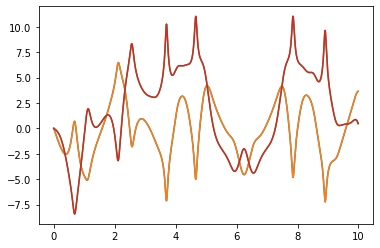

In [16]:
plt.plot(t, X[:,2])
plt.plot(t, Xdot[:,0])

plt.plot(t, X[:,3])
plt.plot(t, Xdot[:,1])
plt.show()


In [17]:
q, qdot, qddot = forward(X)

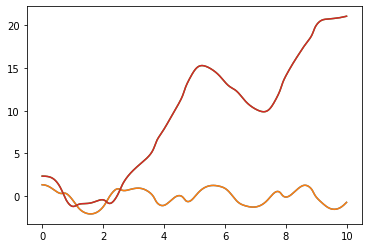

In [18]:
plt.plot(t, X[:,0])
plt.plot(t, q[:,0].detach())

plt.plot(t, X[:,1])
plt.plot(t, q[:,1].detach())
plt.show()


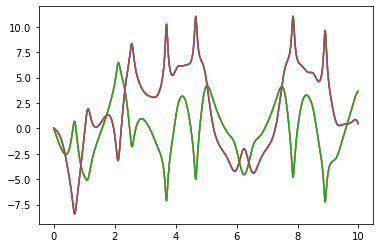

In [19]:
plt.plot(t, Xdot[:,0])
plt.plot(t, qdot[:,0].detach())
plt.plot(t, X[:,2])

plt.plot(t, Xdot[:,1])
plt.plot(t, qdot[:,1].detach())
plt.plot(t, X[:,3])
plt.show()

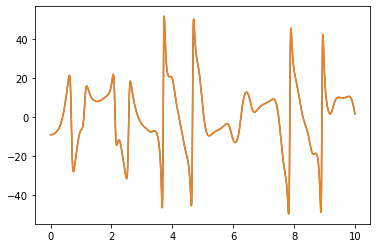

In [24]:
plt.plot(t, Xdot[:,2])
plt.plot(t, qddot[:,0].detach())
plt.show()

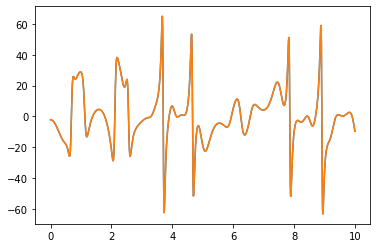

In [23]:
plt.plot(t, Xdot[:,3])
plt.plot(t, qddot[:,1].detach())
plt.show()

In [ ]:
class LNN(nn.Module):
    def __init__(self,hdim):
        super(LNN, self).__init__()
        self.lin1  = nn.Linear(2, hdim)
        self.lin2 = nn.Linear(hdim, hdim)
        self.lin3 = nn.Linear(hdim, 1)
    
    def Lagrangian(self, x):
        hx = F.softplus(self.lin1(x))
        hx = F.softplus(self.lin2(hx))
        L = self.lin3(hx)
        return L.sum()
    
    def forward(x):
        '''
        #input 
        x  : State of the system (q, qdot)

        #output
        qddot : Double derivation of q w.r.t time 
        '''
        if(torch.is_tensor(x)==False):
            x = torch.from_numpy(x)
        
        n = x.shape[1]//2 #number of generalized coordinate
        xv = torch.autograd.Variable(x, requires_grad=True)
        q, qdot = torch.split(xv, n, dim=1)

        #Since the state is in the form of q,qdot,
        #We need to splice the result
        
        #Shape (batch, (nxn) hessian corresponding to each input)
        A = torch.inverse(torch.einsum('ijkl -> ijl', hessian(self.Lagrangian, xv, create_graph=True))[:, n:, n:])
        #Shape (batch, (n) gradient corresponding to each input)
        B = jacobian(self.Lagrangian, xv, create_graph = True)[:,:n]
        #Shape (batch, (nxn) hessian corresponding to each input)
        C = torch.einsum('ijkl -> ijl', hessian(self.Lagrangian, xv, create_graph=True))[:,n:, :n]

        qddot = torch.einsum('ijk, ik -> ij', A, (B - torch.einsum('ijk, ik -> ij', C, qdot))) 

        return qddot

In [ ]:
def forward(x):
        '''
        #input 
        x  : State of the system (q, qdot)

        #output
        qddot : Double derivation of q w.r.t time 
        '''
        if(torch.is_tensor(x)==False):
            x = torch.from_numpy(x)
        
        n = x.shape[1]//2 #number of generalized coordinate
        xv = torch.autograd.Variable(x, requires_grad=True)
        q, qdot = torch.split(xv, n, dim=1)

        #Since the state is in the form of q,qdot,
        #We need to splice the result
        
        #Shape (batch, (nxn) hessian corresponding to each input)
        A = torch.inverse(torch.einsum('ijkl -> ijl', hessian(lagrangian, xv, create_graph=True))[:, n:, n:])
        #Shape (batch, (n) gradient corresponding to each input)
        B = jacobian(lagrangian, xv, create_graph = True)[:,:n]
        #Shape (batch, (nxn) hessian corresponding to each input)
        C = torch.einsum('ijkl -> ijl', hessian(lagrangian, xv, create_graph=True))[:,n:, :n]

        qddot = torch.einsum('ijk, ik -> ij', A, (B - torch.einsum('ijk, ik -> ij', C, qdot))) 
